In [1]:
import cv2
import os

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, ImageDraw
from tensorflow.keras import backend as K
#from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Add, Conv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

In [2]:
IMG_HEIGHT = 264
IMG_WIDTH = 640
X_FACTOR = IMG_WIDTH / 600 # Scale of resizing images
Y_FACTOR = IMG_HEIGHT / 600 # Scale of resizing images
BATCH_SIZE = 128
EPOCHS = 25
learning_rate = 0.003
train_dataset_path = './images/train/'
test_dataset_path = './images/test/'

In [3]:
# Function to read images names and store them in a DataFrame
def grabPaths(filepath):
    labels = [str(filepath[i]).split("/")[-1] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='path').astype(str)
    
    # Concatenate filepaths and labels

    # Shuffle the DataFrame and reset index
    df = pd.DataFrame(filepath)
    
    return df

# Function to scale boxes coordinates (bacuase images are resized)
def resize_boxes(boxes):
    boxes = np.array(boxes).astype(np.float32)
    boxes = boxes * X_FACTOR
    return (np.rint(boxes)).astype(int)


# Function to draw bounding box given an image & coordinates
def plot_bbox(image, yt_box, yp_box=None, norm=False):
    # If image is normalized (/255.) reconstruct (inverse) the operation
    if norm:
        image = image * 255.
        image = image.astype("uint8")
    
    # Convert image to array if not converted
    try:
        pil_img = Image.fromarray(image)
    except:
        pil_img = Image.fromarray(image.astype('uint8'))
        
    draw_img = ImageDraw.Draw(pil_img)
    
    x1, y1, w = yt_box
    h = w
    x2, y2 = x1+w, y1+h
    draw_img.rectangle((x1, y1, x2, y2), outline='green')
    
    # If y_pred box is given, draw it
    if yp_box is not None:
        x1, y1, w = yp_box
        h = w
        x2, y2 = x1+w, y1+h
        draw_img.rectangle((x1, y1, x2, y2), outline='red')
    return pil_img


# Function to build convolutionl block
def convblock(previous_layer, n_filters, filter_windows=(3,3,3), padding='same', pool=None):
    # [DepthwiseConv -> BatchNorm -> LeakyReLU] x3 + Residual connection -> Pooling (optional)

    x = SeparableConv2D(n_filters[0], filter_windows[0], padding=padding)(previous_layer)
    x_short = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[1], filter_windows[1], padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[2], filter_windows[2], padding=padding)(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_short])
    x = LeakyReLU()(x)
    
    if pool == 'max':
        x = MaxPooling2D(pool_size=(2,2))(x)
    elif pool == 'avg':
        x = AveragePooling2D(pool_size=(2,2))(x)
    
    return x

# Function to show samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            batch_index = np.random.randint(0, BATCH_SIZE/2)
            output_classes = np.array(datagen[batch_index][1]['class_out'])
            classes_true = np.where(output_classes == 1)[0]
            sample_index = classes_true[np.random.randint(0, classes_true.shape[0])]
            image = datagen[batch_index][0][sample_index]
            box = datagen[batch_index][1]['box_out'][sample_index]
            plotted_box = plot_bbox(image, box, norm=True)
            ax[i,j].imshow(plotted_box)
            ax[i,j].set_axis_off()
    plt.show()
    


# Function to make a prediction during training
def visualize_prediction(model, data):    
    # Select a sample where an object exists
    output_classes = np.array(custom_test_gen[0][1]['class_out'])
    sample_index = np.where(output_classes == 1)[0]
    sample_index = sample_index[0] if sample_index[0] else 0 
    
    # Get image
    image = np.array([data[0][0][sample_index]])
    
    # Set y_true & y_pred for class & bounding box
    yt_box = np.array([custom_test_gen[0][1]['box_out'][sample_index]])
    yt_class = np.array([custom_test_gen[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))
    plt.show()


# Function to reduce learning rate during training        
def lr_scheduler(epoch, lr):
    if epoch > 10:
        lr = lr * tf.math.exp(-0.15)
        print(lr)
    return float(lr)

# Function to calculate MSE Loss function
# for samples where object exists
def custom_mse(y_true, y_pred):
    mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
    y_true_custom = y_true[mask]
    y_pred_custom = y_pred[mask]
    mse = tf.keras.losses.MeanSquaredError()
    result = mse(y_true_custom, y_pred_custom) # * 0.3
    return result

In [4]:
# Read CSV
train_dataset = pd.read_csv('./images/train/dataset.csv')
train_dataset.columns = ['path', 'ball_exists', 'x', 'y', 'w', 'h']
test_dataset = pd.read_csv('./images/test/dataset.csv')
test_dataset.columns = ['path', 'ball_exists', 'x', 'y', 'w', 'h']


# List directories of files
train_image_dir_hand = Path('./images/train')
train_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.jpg'))
test_image_dir_hand = Path('./images/test')
test_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.jpg'))

# Create dataframe of {paths, labels}
train_df_hand = grabPaths(train_filepaths_hand)
test_df_hand = grabPaths(test_filepaths_hand)

train_dataset['path'] = "./images/train/" + train_dataset['path']
test_dataset['path'] = "./images/test/" + test_dataset['path']


# Resize boxes, keep zeros if no object exists
train_dataset.iloc[:,2:] = resize_boxes(train_dataset.iloc[:,2:])
test_dataset.iloc[:,2:] = resize_boxes(test_dataset.iloc[:,2:])

[Text(0.5, 0, 'Object exists in image'), Text(0, 0.5, 'No. of Image')]

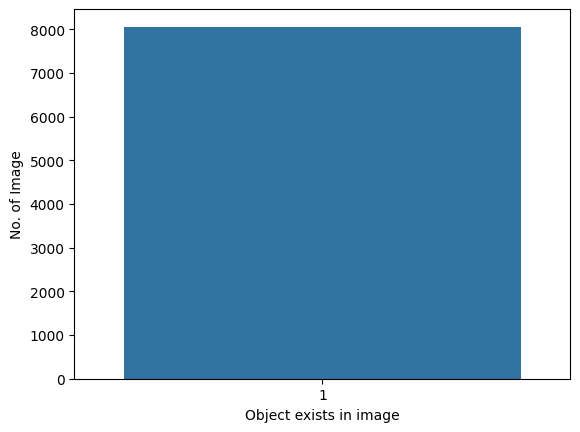

In [5]:
ax = sns.countplot(x='ball_exists', data=train_dataset)
ax.set(xlabel='Object exists in image', ylabel='No. of Image')

In [6]:
# balance dataset (undersampling)
# balls = dataset[dataset['ball_exists'] == 1]
# noballs = dataset[dataset['ball_exists'] == 0]
# balls = balls.sample(frac=0.75).reset_index(drop=True)

# # merge balanced classes & shuffle
# train_df = pd.concat((balls, noballs)).sample(frac=1.).reset_index(drop=True)

# train_df, test_df = train_test_split(train_df, test_size=0.2)

# print(f"No. Training Samples: {train_df.shape[0]}\nNo. Validation Samples: {test_df.shape[0]}")

In [7]:
# Create custom Generator for multiple output models
class MultiOutputGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen, output_gen):
        self.inpgen = input_gen
        self.outgen = output_gen
#         assert len(input_gen) == len(output_gen)

    def __len__(self):
        return len(self.inpgen)

    def __getitem__(self, i):
        images = self.inpgen[i]
        start = i * images.shape[0]
        end = (i+1) * images.shape[0]
        classes_num = self.outgen.iloc[start:end,0].values
        x = self.outgen.iloc[start:end,1]
        y = self.outgen.iloc[start:end,2]
        w = self.outgen.iloc[start:end,3]
#         h = self.outgen.iloc[start:end,4]
        return images, {'class_out':classes_num, 'box_out':np.array([x, y, w]).T}

    def on_epoch_end(self):
        self.inpgen.on_epoch_end()
    
# Class to visualize predictions during training
class ConvergenceVisualization(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global custom_test_gen
        visualize_prediction(self.model, custom_test_gen)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.8, 1.2),
    rescale = 1./255.,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_dataset,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Create multi-output generator
custom_train_gen = MultiOutputGen(train_images, train_dataset.iloc[:,1:])
custom_test_gen = MultiOutputGen(test_images, test_dataset.iloc[:,1:])

Found 8058 validated image filenames.
Found 237 validated image filenames.


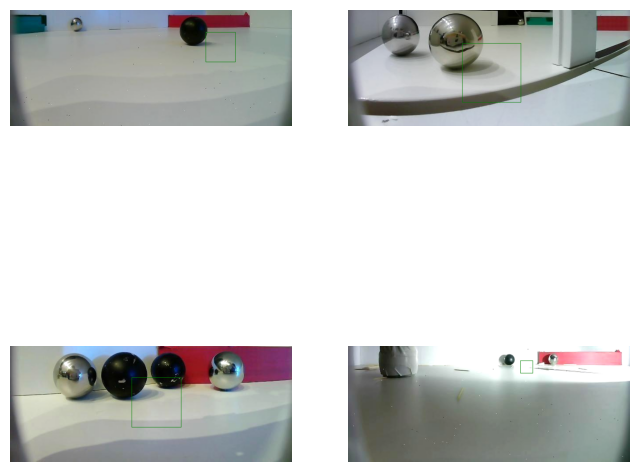

In [9]:
visualize_samples(custom_train_gen, 2)

In [10]:
# BEST MODEL

inp = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3), name='image')

X = SeparableConv2D(64, (7,7), strides=2, padding='valid')(inp)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = SeparableConv2D(192, (3,3), strides=1, padding='same')(X)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = convblock(X, [16, 16, 16], pool='max')
X = convblock(X, [32, 32, 32], pool='max')
X = convblock(X, [64, 64, 64], pool='max')
X = convblock(X, [128, 128, 128], pool='max')
X = convblock(X, [256, 256, 256])

X = Flatten()(X)
boxX = Dense(512)(X)
boxX = LeakyReLU()(boxX)

classX = Dense(128)(X)
classX = LeakyReLU()(classX)

box_out = Dense(3, name='box_out')(boxX)
class_out = Dense(1, name='class_out', activation='sigmoid')(classX)


model = Model(inp, [class_out, box_out])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 264, 640, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 129, 317, 64)      │             403 │ image[0][0]                │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 158, 64)       │               0 │ separable_conv2d[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 64, 158, 192)      │          13,056 │ max_pooling2d[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 79, 192)       │               0 │ separable_conv2d_1[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_2            │ (None, 32, 79, 16)        │           4,816 │ max_pooling2d_1[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 79, 16)        │              64 │ separable_conv2d_2[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 32, 79, 16)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_3            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu[0][0]          │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_3[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 32, 79, 16)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_4            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu_1[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_4[0][0]   │
│ (BatchNormalization)          │                           │               

 Total params: 1,567,927 (5.98 MB)

 Trainable params: 1,564,951 (5.97 MB)

 Non-trainable params: 2,976 (11.62 KB)

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss={
        "box_out":custom_mse,
        'class_out':'binary_crossentropy'
    },
    metrics={
        'class_out':'accuracy'
    },
    optimizer=adam
)

C:\Users\Salkin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step- box_out_loss: 18769.2852 - class_out_accuracy: 0.9402 - class_out_loss: 0.0765 - loss: 18768.9980  
Class: y_true= [1]  | y_pred= 1


C:\Users\Salkin\AppData\Local\Temp\ipykernel_23976\1157806439.py:116: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))


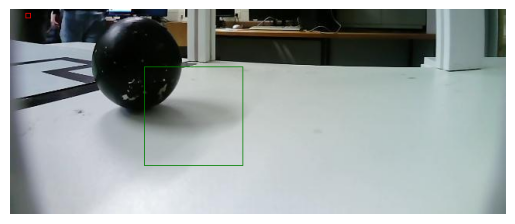

63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - box_out_loss: 18659.4238 - class_out_accuracy: 0.9409 - class_out_loss: 0.0756 - loss: 18659.1074 - val_box_out_loss: 55269.7500 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 8.4123e-05 - val_loss: 55427.9922 - learning_rate: 0.0030
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 7328.7456 - class_out_accuracy: 1.0000 - class_out_loss: 6.5639e-21 - loss: 7327.3687 
Class: y_true= [1]  | y_pred= 1


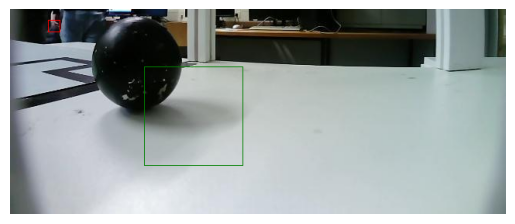

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 857ms/step - box_out_loss: 7325.4497 - class_out_accuracy: 1.0000 - class_out_loss: 7.8783e-21 - loss: 7323.9912 - val_box_out_loss: 48228.1758 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.3423e-09 - val_loss: 48374.7344 - learning_rate: 0.0030
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 5817.0469 - class_out_accuracy: 1.0000 - class_out_loss: 5.5326e-17 - loss: 5813.6274 
Class: y_true= [1]  | y_pred= 1


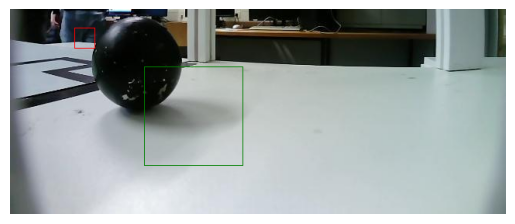

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 860ms/step - box_out_loss: 5817.2300 - class_out_accuracy: 1.0000 - class_out_loss: 5.5429e-17 - loss: 5813.7505 - val_box_out_loss: 40678.8555 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.9200e-15 - val_loss: 40811.4844 - learning_rate: 0.0030
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 5505.0864 - class_out_accuracy: 1.0000 - class_out_loss: 3.2744e-15 - loss: 5480.4619 
Class: y_true= [1]  | y_pred= 1


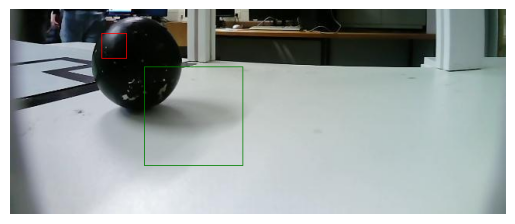

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 848ms/step - box_out_loss: 5494.4336 - class_out_accuracy: 1.0000 - class_out_loss: 3.3119e-15 - loss: 5470.0708 - val_box_out_loss: 34144.4297 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 8.5634e-22 - val_loss: 34263.2617 - learning_rate: 0.0030
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 4141.7212 - class_out_accuracy: 1.0000 - class_out_loss: 8.2418e-15 - loss: 4132.1323 
Class: y_true= [1]  | y_pred= 1


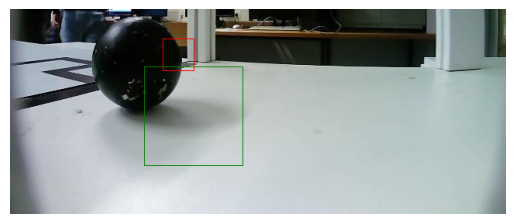

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 861ms/step - box_out_loss: 4143.7051 - class_out_accuracy: 1.0000 - class_out_loss: 8.3093e-15 - loss: 4134.1377 - val_box_out_loss: 23200.3418 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.2481e-32 - val_loss: 23289.5977 - learning_rate: 0.0030
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 3246.1218 - class_out_accuracy: 1.0000 - class_out_loss: 3.3094e-12 - loss: 3242.8042 
Class: y_true= [1]  | y_pred= 1


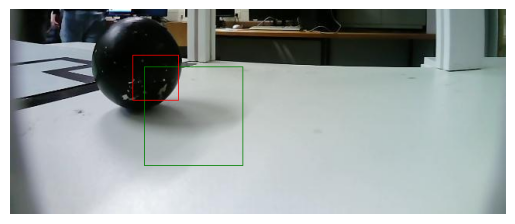

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 848ms/step - box_out_loss: 3249.3633 - class_out_accuracy: 1.0000 - class_out_loss: 3.3700e-12 - loss: 3245.9512 - val_box_out_loss: 17482.1445 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.3997e-28 - val_loss: 17455.5000 - learning_rate: 0.0030
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 3210.5698 - class_out_accuracy: 1.0000 - class_out_loss: 9.5409e-10 - loss: 3192.4260 
Class: y_true= [1]  | y_pred= 1


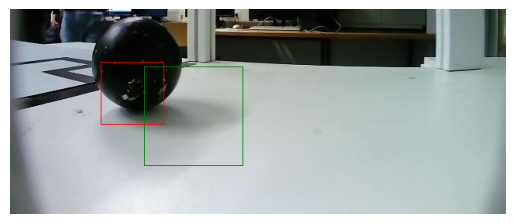

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - box_out_loss: 3204.6335 - class_out_accuracy: 1.0000 - class_out_loss: 9.5180e-10 - loss: 3186.6411 - val_box_out_loss: 18651.6953 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 3.2165e-15 - val_loss: 18369.7305 - learning_rate: 0.0030
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 2592.0886 - class_out_accuracy: 1.0000 - class_out_loss: 7.4819e-10 - loss: 2578.0239 
Class: y_true= [1]  | y_pred= 1


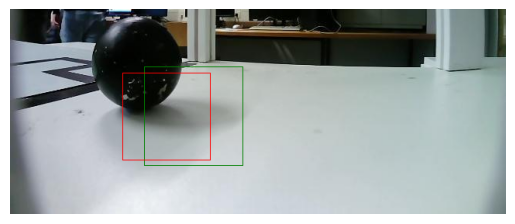

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 856ms/step - box_out_loss: 2589.7222 - class_out_accuracy: 1.0000 - class_out_loss: 7.6949e-10 - loss: 2575.7180 - val_box_out_loss: 12603.9492 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.3465e-14 - val_loss: 12220.8848 - learning_rate: 0.0030
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 1967.8812 - class_out_accuracy: 1.0000 - class_out_loss: 2.2187e-09 - loss: 1963.4298 
Class: y_true= [1]  | y_pred= 1


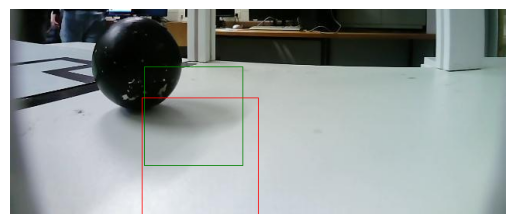

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 849ms/step - box_out_loss: 1971.3245 - class_out_accuracy: 1.0000 - class_out_loss: 2.3872e-09 - loss: 1966.7786 - val_box_out_loss: 11849.5957 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 2.1209e-14 - val_loss: 11247.5166 - learning_rate: 0.0030
Epoch 10/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 1687.7146 - class_out_accuracy: 1.0000 - class_out_loss: 3.2899e-09 - loss: 1684.2981 
Class: y_true= [1]  | y_pred= 1


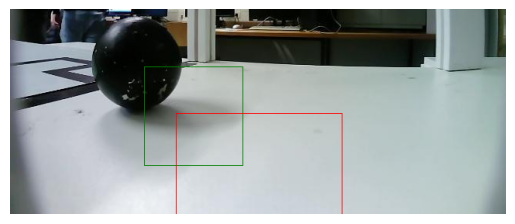

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 849ms/step - box_out_loss: 1690.0293 - class_out_accuracy: 1.0000 - class_out_loss: 3.2991e-09 - loss: 1686.5059 - val_box_out_loss: 16939.6973 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 5.7138e-12 - val_loss: 16075.3125 - learning_rate: 0.0030
Epoch 11/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 1814.8535 - class_out_accuracy: 1.0000 - class_out_loss: 2.2158e-10 - loss: 1797.0565 
Class: y_true= [1]  | y_pred= 1


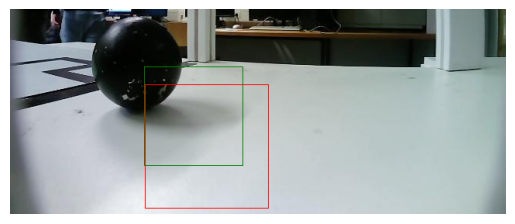

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - box_out_loss: 1810.2583 - class_out_accuracy: 1.0000 - class_out_loss: 2.2805e-10 - loss: 1792.6190 - val_box_out_loss: 13710.4902 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.9978e-17 - val_loss: 12997.5283 - learning_rate: 0.0030
tf.Tensor(0.002582124, shape=(), dtype=float32)
Epoch 12/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 1000.2248 - class_out_accuracy: 1.0000 - class_out_loss: 1.6816e-10 - loss: 997.5173  
Class: y_true= [1]  | y_pred= 1


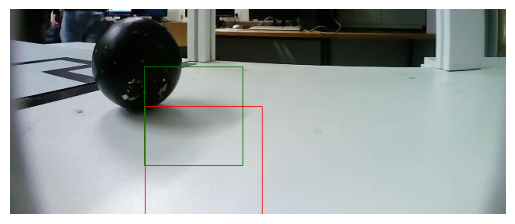

63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 845ms/step - box_out_loss: 1002.8333 - class_out_accuracy: 1.0000 - class_out_loss: 1.6802e-10 - loss: 1000.0109 - val_box_out_loss: 13412.6670 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 7.8035e-15 - val_loss: 12640.1914 - learning_rate: 0.0026
tf.Tensor(0.0022224546, shape=(), dtype=float32)
Epoch 13/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 831.1582 - class_out_accuracy: 1.0000 - class_out_loss: 1.0991e-09 - loss: 829.8019 
Class: y_true= [1]  | y_pred= 1


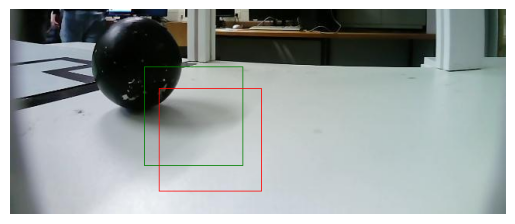

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - box_out_loss: 833.0146 - class_out_accuracy: 1.0000 - class_out_loss: 1.1061e-09 - loss: 831.5408 - val_box_out_loss: 12423.4414 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 4.4037e-16 - val_loss: 11706.1074 - learning_rate: 0.0022
tf.Tensor(0.0019128845, shape=(), dtype=float32)
Epoch 14/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 720.0804 - class_out_accuracy: 1.0000 - class_out_loss: 3.2536e-09 - loss: 714.5552 
Class: y_true= [1]  | y_pred= 1


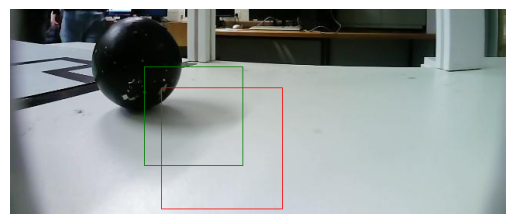

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 846ms/step - box_out_loss: 721.0920 - class_out_accuracy: 1.0000 - class_out_loss: 3.2565e-09 - loss: 715.5345 - val_box_out_loss: 12133.2549 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 2.2603e-15 - val_loss: 11458.5000 - learning_rate: 0.0019
tf.Tensor(0.001646435, shape=(), dtype=float32)
Epoch 15/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 1045.7494 - class_out_accuracy: 1.0000 - class_out_loss: 4.8362e-11 - loss: 1024.0702 
Class: y_true= [1]  | y_pred= 1


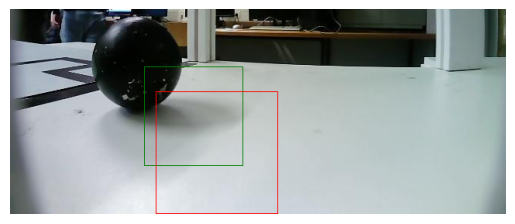

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 849ms/step - box_out_loss: 1039.9852 - class_out_accuracy: 1.0000 - class_out_loss: 4.8285e-11 - loss: 1018.5280 - val_box_out_loss: 11757.3096 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 2.7103e-14 - val_loss: 11039.5693 - learning_rate: 0.0016
tf.Tensor(0.0014170997, shape=(), dtype=float32)
Epoch 16/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 480.6079 - class_out_accuracy: 1.0000 - class_out_loss: 2.3532e-11 - loss: 476.0517 
Class: y_true= [1]  | y_pred= 1


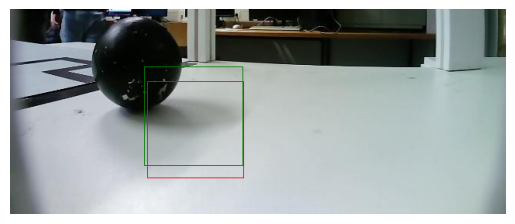

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 853ms/step - box_out_loss: 481.7302 - class_out_accuracy: 1.0000 - class_out_loss: 2.3536e-11 - loss: 477.1334 - val_box_out_loss: 11685.3154 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 2.8649e-16 - val_loss: 11056.8418 - learning_rate: 0.0014
tf.Tensor(0.001219709, shape=(), dtype=float32)
Epoch 17/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 616.7765 - class_out_accuracy: 1.0000 - class_out_loss: 1.0493e-10 - loss: 604.9192 
Class: y_true= [1]  | y_pred= 1


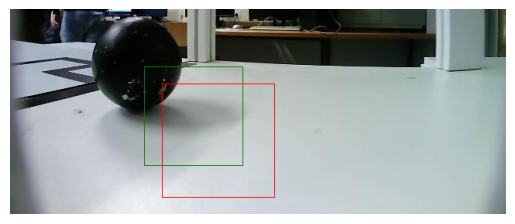

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - box_out_loss: 614.7748 - class_out_accuracy: 1.0000 - class_out_loss: 1.0598e-10 - loss: 603.0021 - val_box_out_loss: 11823.0762 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 3.4410e-16 - val_loss: 11126.8350 - learning_rate: 0.0012
tf.Tensor(0.0010498133, shape=(), dtype=float32)
Epoch 18/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 364.8459 - class_out_accuracy: 1.0000 - class_out_loss: 2.1787e-11 - loss: 361.8556 
Class: y_true= [1]  | y_pred= 1


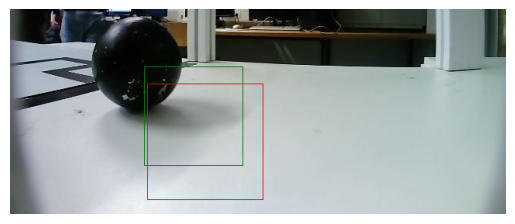

63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 838ms/step - box_out_loss: 366.3478 - class_out_accuracy: 1.0000 - class_out_loss: 2.2021e-11 - loss: 363.3001 - val_box_out_loss: 12720.5273 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.1369e-15 - val_loss: 12005.3379 - learning_rate: 0.0010
tf.Tensor(0.0009035827, shape=(), dtype=float32)
Epoch 19/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 346.9843 - class_out_accuracy: 1.0000 - class_out_loss: 1.2306e-10 - loss: 343.7760 
Class: y_true= [1]  | y_pred= 1


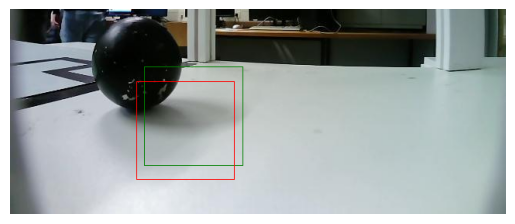

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 819ms/step - box_out_loss: 348.1068 - class_out_accuracy: 1.0000 - class_out_loss: 1.2257e-10 - loss: 344.8577 - val_box_out_loss: 11965.8877 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 2.9358e-14 - val_loss: 11291.3320 - learning_rate: 9.0358e-04
tf.Tensor(0.0007777209, shape=(), dtype=float32)
Epoch 20/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 343.2893 - class_out_accuracy: 1.0000 - class_out_loss: 4.2910e-10 - loss: 339.4507 
Class: y_true= [1]  | y_pred= 1


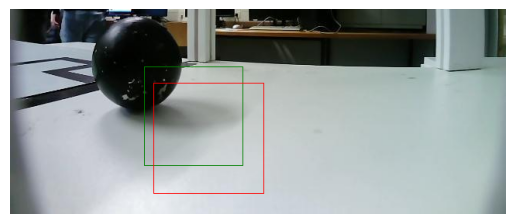

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 828ms/step - box_out_loss: 343.9164 - class_out_accuracy: 1.0000 - class_out_loss: 4.2421e-10 - loss: 340.0476 - val_box_out_loss: 11689.0742 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.3520e-15 - val_loss: 11058.4961 - learning_rate: 7.7772e-04
tf.Tensor(0.0006693906, shape=(), dtype=float32)
Epoch 21/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 245.3782 - class_out_accuracy: 1.0000 - class_out_loss: 2.1526e-10 - loss: 244.1533 
Class: y_true= [1]  | y_pred= 1


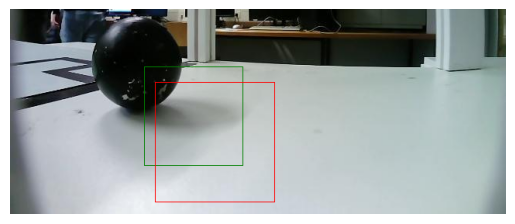

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 826ms/step - box_out_loss: 246.8663 - class_out_accuracy: 1.0000 - class_out_loss: 2.1449e-10 - loss: 245.5768 - val_box_out_loss: 11432.4492 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.3113e-16 - val_loss: 10816.9678 - learning_rate: 6.6939e-04
tf.Tensor(0.00057614985, shape=(), dtype=float32)
Epoch 22/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 233.4286 - class_out_accuracy: 1.0000 - class_out_loss: 7.0763e-11 - loss: 232.4615 
Class: y_true= [1]  | y_pred= 1


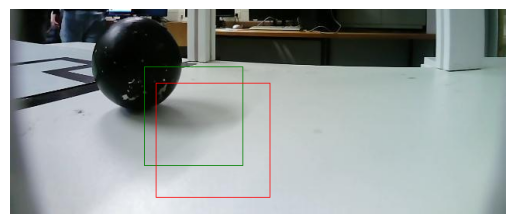

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 829ms/step - box_out_loss: 234.8915 - class_out_accuracy: 1.0000 - class_out_loss: 7.1477e-11 - loss: 233.8600 - val_box_out_loss: 11420.0879 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 7.2509e-18 - val_loss: 10838.8291 - learning_rate: 5.7615e-04
tf.Tensor(0.0004958968, shape=(), dtype=float32)
Epoch 23/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 217.5368 - class_out_accuracy: 1.0000 - class_out_loss: 1.8024e-10 - loss: 216.7970 
Class: y_true= [1]  | y_pred= 1


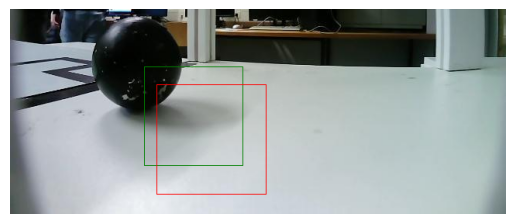

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 826ms/step - box_out_loss: 219.0298 - class_out_accuracy: 1.0000 - class_out_loss: 1.7997e-10 - loss: 218.2258 - val_box_out_loss: 11431.5352 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 2.0599e-17 - val_loss: 10865.8965 - learning_rate: 4.9590e-04
tf.Tensor(0.00042682234, shape=(), dtype=float32)
Epoch 24/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 276.9305 - class_out_accuracy: 1.0000 - class_out_loss: 3.6002e-11 - loss: 273.5409 
Class: y_true= [1]  | y_pred= 1


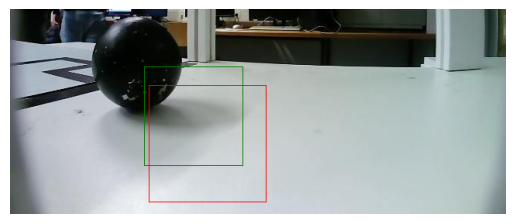

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 825ms/step - box_out_loss: 277.2141 - class_out_accuracy: 1.0000 - class_out_loss: 3.8373e-11 - loss: 273.8108 - val_box_out_loss: 11799.0244 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 3.6039e-16 - val_loss: 11152.8252 - learning_rate: 4.2682e-04
tf.Tensor(0.00036736942, shape=(), dtype=float32)
Epoch 25/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 237.4512 - class_out_accuracy: 1.0000 - class_out_loss: 2.1392e-11 - loss: 234.7811 
Class: y_true= [1]  | y_pred= 1


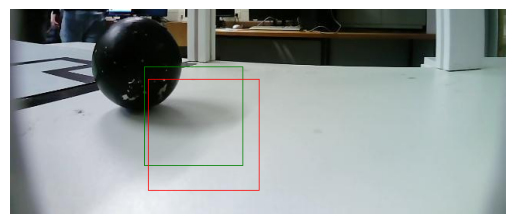

63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 819ms/step - box_out_loss: 238.0885 - class_out_accuracy: 1.0000 - class_out_loss: 2.1485e-11 - loss: 235.3946 - val_box_out_loss: 11920.6006 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 1.7302e-16 - val_loss: 11258.0010 - learning_rate: 3.6737e-04


In [12]:
history = model.fit(
    custom_train_gen,
    epochs=EPOCHS,
    validation_data=custom_test_gen,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
        ConvergenceVisualization()
    ]
)

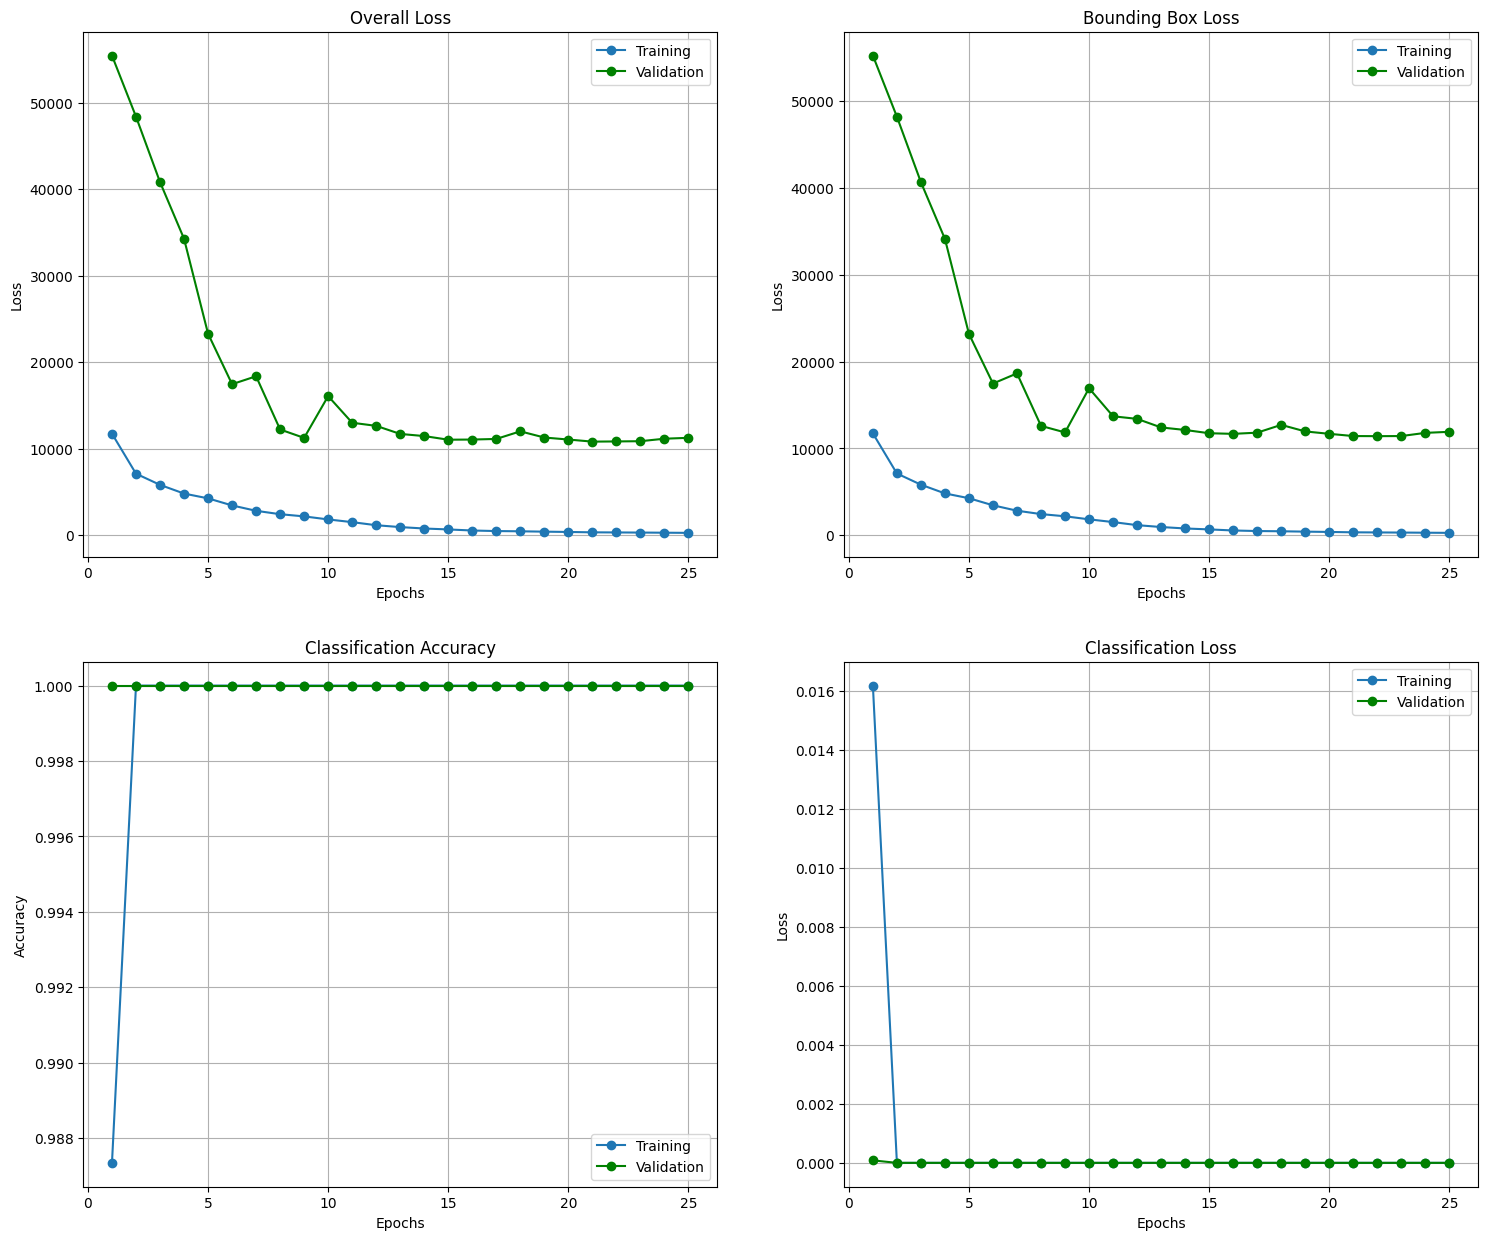

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# Accuracy & Loss Visualization

#  Overall Loss
train_overall_loss = history.history['loss']
val_overall_loss = history.history['val_loss']

# Classification Accuracy
train_classification_acc = history.history['class_out_accuracy']
val_classification_acc = history.history['val_class_out_accuracy']

# Classification Loss
train_classification_loss = history.history['class_out_loss']
val_classification_loss = history.history['val_class_out_loss']

# Bounding Box Loss
train_bbox_loss = history.history['box_out_loss']
val_bbox_loss = history.history['val_box_out_loss']

epochs = range(1, len(history.history['loss'])+1)

f, ax = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
    
ax[0,0].plot(epochs, train_overall_loss,  marker='o', label='Training')
ax[0,0].plot(epochs, val_overall_loss, marker='o', color = 'green', label='Validation')
ax[0,0].set_title('Overall Loss')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend(loc='best')
ax[0,0].grid(True)

ax[0,1].plot(epochs, train_bbox_loss, marker='o', label='Training')
ax[0,1].plot(epochs, val_bbox_loss, marker='o', color = 'green', label='Validation')
ax[0,1].set_title('Bounding Box Loss')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend(loc='best')
ax[0,1].grid(True)



ax[1,0].plot(epochs, train_classification_acc,  marker='o', label='Training')
ax[1,0].plot(epochs, val_classification_acc, marker='o', color = 'green', label='Validation')
ax[1,0].set_title('Classification Accuracy')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].legend(loc='best')
ax[1,0].grid(True)

ax[1,1].plot(epochs, train_classification_loss, marker='o', label='Training')
ax[1,1].plot(epochs, val_classification_loss, marker='o', color = 'green', label='Validation')
ax[1,1].set_title('Classification Loss')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend(loc='best')
ax[1,1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()

In [14]:
model.save("test1 ball detection.h5")